<a href="https://colab.research.google.com/github/ppen/DemoAPI/blob/master/Kaidee_CarPredicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1d8cTTuOiEDfLFJVuC57RHyrqccxZgAVP
!unzip rod.kaidee.dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1d8cTTuOiEDfLFJVuC57RHyrqccxZgAVP
To: /content/rod.kaidee.dataset.zip
3.10MB [00:00, 86.8MB/s]
Archive:  rod.kaidee.dataset.zip
  inflating: data_source.txt         
  inflating: test.csv                
  inflating: train.csv               


# **Botnoi Mini Project: Prediction price of secound hand cars **

หลังจากที่ทุกคนได้เรียนเรื่อง feature engineering กับ time series prediction กันไปแล้ว วันนี้เราจะมาเรียนการลองสร้างโมเดลทำนายราคาของรถมือสองกัน มาเริ่มกันเลย

![alt text](https://s.isanook.com/au/0/rp/r/w728/ya0xa0m1w0/aHR0cHM6Ly9zLmlzYW5vb2suY29tL2F1LzAvdWQvMTMvNjYxODMvMjAwLmpwZw==.jpg)

ขั้นแรกก็เริ่มจากการ import library กันเลยค่ะ 

# Import Library

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import median
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import warnings
import glob
import os 
import time
import functools
import datetime as dt
from datetime import datetime
from IPython.display import display_html
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_predict
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
plt.style.use('bmh')

In [ ]:
#Set Pandas
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('expand_frame_repr', False); pd.set_option('max_colwidth',1000)
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',1000)
#Set warning
warnings.filterwarnings("ignore")

สร้าง user define function

# Define Functions

In [ ]:
def count_na(data):
    na_count = pd.DataFrame(data.isnull().sum(), columns=['Count']).sort_values(by=['Count'], ascending=False)
    na_count = na_count[na_count["Count"]>0]
    return na_count

In [ ]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
def split_data_label(df):
  label = df['price']
  data = df.drop('price', axis=1)
  return data, label

In [ ]:
def train_model(feat, label,params):
  model = GradientBoostingRegressor(
**params
  )
  model.fit(feat, label)
  return model

In [ ]:
def eval_acc(prediction, actual):
  acc = sum(prediction == actual) / len(actual)
  return acc

In [ ]:
def extract_feat(df):
  feat = df.copy()
  feat = feat.drop(["chk_desc","chk_mileage","chk_transmission","chk_color"], axis=1)
  feat = pd.concat([feat,pd.get_dummies(feat['location'])],axis=1)     
  feat = pd.concat([feat,pd.get_dummies(feat['brand'])],axis=1)  
  feat = pd.concat([feat,pd.get_dummies(feat['model'])],axis=1) 
  feat = pd.concat([feat,pd.get_dummies(feat['fuel'])],axis=1)   
#   feat = pd.concat([feat,pd.get_dummies(feat['C_Text'])],axis=1)   
  feat = pd.concat([feat,pd.get_dummies(feat['transmission'])],axis=1)  
  feat = pd.concat([feat,pd.get_dummies(feat['color'])],axis=1)  
  feat = pd.concat([feat,pd.get_dummies(feat['car_type'])],axis=1) 
  feat = feat._get_numeric_data()
  return feat

# **Download data from Rod Kaidee**

*   Data consisting: train.csv, test.csv

ภายหลังจากเราโหลดข้อมูลเข้า google colab แล้ว เราจะกำหนดให้

train data = train_df (from 'train.csv')
test data = test_df (from 'test.csv')

# Import Data

โหลดข้อมูลเสร็จแล้วก็มาดูกันต่อว่าข้อมูลที่เราโหลดมาเนี่ย ประกอบไปด้วยข้อมูลอะไรบ้าง โดยจากตัวอย่างข้อมูลที่เราโหลดมาเราจะเห็นได้ว่า ข้อมูลที่ใช้ในการซื้อขายรถมือสองนั้นประกอบด้วย

1. Price = ราคา
2. Desc = คำอธิบายสำหรับข้อมูลเกี่ยวกับรถนั้นๆ
3. ad_id = advertisment ID
4. location = จังหวัด
5. timestamp =
6.  mileage = เลขไมล์
7.  brand = ยี่ห้อ
8.  model = รุ่น
9.  year = ปี
10. fuel = ชนิดของเชื้อเพลิงที่ใช้
11. transmission = ชนิดของเกียร์รถยนต์
color= สี
cartype = ชนิดของรถ

In [ ]:
df_raw_test = pd.read_csv(r"test.csv")
df_raw_train = pd.read_csv(r"train.csv")
display_side_by_side(df_raw_test.head(1),df_raw_train.head(1))

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
0,549000,"Option: เครื่องเล่น CD, USB, กระจกไฟฟ้า, เซ็นทรัลล็อค, พวงมาลัยพาวเวอร์, ABS/AIRBAG 6 ใบ ,ไฟตัดหมอก ,กระจกมองข้างปรับไฟฟ้าแบบโครเมี่ยม ,ไฟเลี้ยวที่กระจกมองข้าง ,ไมล์ดิจิตอล ,กุญแจรีโมท ,พวงมาลัยMultifunction ,Cruse Control, พื้นปูกระบะ บันไดข้าง\n,Park Sensor\n#สู้ด้วยกัน",354696215,นนทบุรี,1586421506,31200,Ford,Ranger,2017,ดีเซล,เกียร์อัตโนมัติ,ดำ,รถกระบะ
,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
0,569000,"""เลขไมล์5,700กิโลแท้ 1.3 SP โฉมปัจจุบัน รถ2เดือน มือเดียวไม่เคยชน100% รถยังเป็นป้ายแดง ยังไม่ได้จดทะเบียน สามารถจดเป็นมือแรกได้เลย""\n\nรถบ้าน มือเดียว ปี20แท้ รุ่นTopสุด 1.3 SP เกียร์Paddleshift เบาะหนังแท้ จอ+กล้อง360รอบคัน สภาพดีมาก ภายในใหม่สะอาด เดิมทั้งคัน ไม่เคยชน100% ไมล์5,000กิโลแท้ คู่มือBookserviceครบ เหมือนรถใหม่ สวยทุกจุด\n\n\n""ดอกเบี้ยเริ่มต้น 2.79%4ปี 2.99%5ปี 3.89%6ปี""\n\n\nติดต่อ: 0814120644\nLine: golff6\nสถานที่ดูรถ: เยื้องเดอะมอลล์ท่าพระ ตรงข้ามปั๊มเชลล์",354186401,กรุงเทพมหานคร,1584521455,5700,Mazda,Mazda2 Sport,2020,เบนซิน,เกียร์อัตโนมัติ,เทา,รถเก๋ง


In [ ]:
print(df_raw_test.head(1),df_raw_train.head(1))

    price                                                                                                                                                                                                                                                                              desc      ad_id location   timestamp mileage brand   model  year   fuel     transmission color car_type
0  549000  Option: เครื่องเล่น CD, USB, กระจกไฟฟ้า, เซ็นทรัลล็อค, พวงมาลัยพาวเวอร์, ABS/AIRBAG 6 ใบ ,ไฟตัดหมอก ,กระจกมองข้างปรับไฟฟ้าแบบโครเมี่ยม ,ไฟเลี้ยวที่กระจกมองข้าง ,ไมล์ดิจิตอล ,กุญแจรีโมท ,พวงมาลัยMultifunction ,Cruse Control, พื้นปูกระบะ บันไดข้าง\n,Park Sensor\n#สู้ด้วยกัน  354696215  นนทบุรี  1586421506   31200  Ford  Ranger  2017  ดีเซล  เกียร์อัตโนมัติ    ดำ  รถกระบะ     price                                                                                                                                                                                                                                 

In [ ]:
df_raw_test.head(1)
df_raw_train.head(1)

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
0,569000,"""เลขไมล์5,700กิโลแท้ 1.3 SP โฉมปัจจุบัน รถ2เดือน มือเดียวไม่เคยชน100% รถยังเป็นป้ายแดง ยังไม่ได้จดทะเบียน สามารถจดเป็นมือแรกได้เลย""\n\nรถบ้าน มือเดียว ปี20แท้ รุ่นTopสุด 1.3 SP เกียร์Paddleshift เบาะหนังแท้ จอ+กล้อง360รอบคัน สภาพดีมาก ภายในใหม่สะอาด เดิมทั้งคัน ไม่เคยชน100% ไมล์5,000กิโลแท้ คู่มือBookserviceครบ เหมือนรถใหม่ สวยทุกจุด\n\n\n""ดอกเบี้ยเริ่มต้น 2.79%4ปี 2.99%5ปี 3.89%6ปี""\n\n\nติดต่อ: 0814120644\nLine: golff6\nสถานที่ดูรถ: เยื้องเดอะมอลล์ท่าพระ ตรงข้ามปั๊มเชลล์",354186401,กรุงเทพมหานคร,1584521455,5700,Mazda,Mazda2 Sport,2020,เบนซิน,เกียร์อัตโนมัติ,เทา,รถเก๋ง


In [ ]:
df_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103 entries, 0 to 7102
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         7103 non-null   int64 
 1   desc          6932 non-null   object
 2   ad_id         7103 non-null   int64 
 3   location      7103 non-null   object
 4   timestamp     7103 non-null   int64 
 5   mileage       5441 non-null   object
 6   brand         7103 non-null   object
 7   model         7103 non-null   object
 8   year          7103 non-null   int64 
 9   fuel          7103 non-null   object
 10  transmission  6890 non-null   object
 11  color         6848 non-null   object
 12  car_type      7103 non-null   object
dtypes: int64(4), object(9)
memory usage: 721.5+ KB


In [ ]:
df_raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1776 non-null   int64 
 1   desc          1733 non-null   object
 2   ad_id         1776 non-null   int64 
 3   location      1776 non-null   object
 4   timestamp     1776 non-null   int64 
 5   mileage       1360 non-null   object
 6   brand         1776 non-null   object
 7   model         1776 non-null   object
 8   year          1776 non-null   int64 
 9   fuel          1776 non-null   object
 10  transmission  1722 non-null   object
 11  color         1707 non-null   object
 12  car_type      1776 non-null   object
dtypes: int64(4), object(9)
memory usage: 180.5+ KB


# Cleaning Data

In [ ]:
count_na(df_raw_test)

,Count
mileage,416
color,69
transmission,54
desc,43


In [ ]:
count_na(df_raw_train)

,Count
mileage,1662
color,255
transmission,213
desc,171


In [ ]:
print(df_raw_test.shape,df_raw_train.shape)

(1776, 13) (7103, 13)


In [ ]:
df_raw_train.describe(include='all')

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
count,"7,103.0000",6932,"7,103.0000",7103,"7,103.0000",5441,7103,7103,"7,103.0000",7103,6890,6848,7103
unique,nan,6618,nan,72,nan,1652,25,314,nan,9,2,15,5
top,nan,โปรโมชั่นพิเศษทางร้าน...\n- ดาวน์ต่ำ เริ่มต้น 0%\n- อนุมัติไว เอกสารครบ รอรับรถได้เลย ไม่ยุ่งยาก\n- จัดไฟแนนซ์ทั่วไทย อยู่จังหวัดไหนก็ซื้อได้\n- ตรวจสอบและเช็คสภาพรถก่อนส่งรถโดยผู้เชี่ยวชาญ\n- ดูรถไม่เป็นก็ซื้อได้ \n- เราดูแลให้คำปรึกษาท่านทุกอย่างด้วยประสบการณ์กว่า 20 ปี\n- รับประกันไม่มีชนหนัก หรือ คว่ำ\n- ไมล์แท้ 100% (ถ้าไมล์ไม่แท้ รับซื้อคืน 100% ระบุในสัญญา)\n- การันตีด้วยการเป็นสมาชิกสมาคมผู้ประกอบการรถยนต์ใช้แล้ว\n\nช่องทางการติดต่อ \n\n 062-2476823\n\n LINE : https://line.me/ti/p/1zycvPEnkb,nan,กรุงเทพมหานคร,nan,100000,Toyota,D-MAX,nan,เบนซิน,เกียร์อัตโนมัติ,ขาว,รถเก๋ง
freq,nan,37,nan,4217,nan,186,2176,353,nan,4063,5292,2024,3792
mean,"558,230.0348",NaN,"355,018,337.4836",NaN,"1,587,394,596.5537",NaN,NaN,NaN,"2,011.7836",NaN,NaN,NaN,NaN
std,"787,941.8768",NaN,"6,124,893.2282",NaN,"7,063,017.9992",NaN,NaN,NaN,6.0592,NaN,NaN,NaN,NaN
min,999.0000,NaN,"131,380,510.0000",NaN,"1,493,269,132.0000",NaN,NaN,NaN,"1,965.0000",NaN,NaN,NaN,NaN
25%,"259,000.0000",NaN,"354,901,691.0000",NaN,"1,587,025,935.5000",NaN,NaN,NaN,"2,010.0000",NaN,NaN,NaN,NaN
50%,"378,000.0000",NaN,"355,728,961.0000",NaN,"1,589,508,326.0000",NaN,NaN,NaN,"2,013.0000",NaN,NaN,NaN,NaN
75%,"569,000.0000",NaN,"356,192,973.5000",NaN,"1,590,915,844.0000",NaN,NaN,NaN,"2,016.0000",NaN,NaN,NaN,NaN


In [ ]:
df_raw_test.describe(include='all')

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
count,"1,776.0000",1733,"1,776.0000",1776,"1,776.0000",1360,1776,1776,"1,776.0000",1776,1722,1707,1776
unique,nan,1696,nan,57,nan,554,25,210,nan,8,2,13,5
top,nan,โปรโมชั่นพิเศษทางร้าน...\n- ดาวน์ต่ำ เริ่มต้น 0%\n- อนุมัติไว เอกสารครบ รอรับรถได้เลย ไม่ยุ่งยาก\n- จัดไฟแนนซ์ทั่วไทย อยู่จังหวัดไหนก็ซื้อได้\n- ตรวจสอบและเช็คสภาพรถก่อนส่งรถโดยผู้เชี่ยวชาญ\n- ดูรถไม่เป็นก็ซื้อได้ \n- เราดูแลให้คำปรึกษาท่านทุกอย่างด้วยประสบการณ์กว่า 20 ปี\n- รับประกันไม่มีชนหนัก หรือ คว่ำ\n- ไมล์แท้ 100% (ถ้าไมล์ไม่แท้ รับซื้อคืน 100% ระบุในสัญญา)\n- การันตีด้วยการเป็นสมาชิกสมาคมผู้ประกอบการรถยนต์ใช้แล้ว\n\nช่องทางการติดต่อ \n\n 062-2476823\n\n LINE : https://line.me/ti/p/1zycvPEnkb,nan,กรุงเทพมหานคร,nan,100000,Toyota,D-MAX,nan,เบนซิน,เกียร์อัตโนมัติ,ขาว,รถเก๋ง
freq,nan,8,nan,1064,nan,61,544,89,nan,969,1277,524,917
mean,"541,979.6267",NaN,"354,896,334.3001",NaN,"1,587,242,730.3187",NaN,NaN,NaN,"2,011.9071",NaN,NaN,NaN,NaN
std,"609,899.2673",NaN,"7,548,284.9829",NaN,"7,362,971.6413",NaN,NaN,NaN,5.8759,NaN,NaN,NaN,NaN
min,"15,000.0000",NaN,"135,576,057.0000",NaN,"1,503,463,778.0000",NaN,NaN,NaN,"1,956.0000",NaN,NaN,NaN,NaN
25%,"259,000.0000",NaN,"354,811,738.2500",NaN,"1,586,763,906.5000",NaN,NaN,NaN,"2,010.0000",NaN,NaN,NaN,NaN
50%,"379,000.0000",NaN,"355,659,145.0000",NaN,"1,589,282,445.5000",NaN,NaN,NaN,"2,013.0000",NaN,NaN,NaN,NaN
75%,"575,750.0000",NaN,"356,193,643.2500",NaN,"1,590,916,960.0000",NaN,NaN,NaN,"2,016.0000",NaN,NaN,NaN,NaN


In [ ]:
df_raw_train[df_raw_train["mileage"].str.isdigit()==False]  #Show mileage column that doesn't have numeric value for train data set.

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
414,360000,Vios1.5 TRD 2014 จ่อทัชพร้อมรีโหมด ยางใหม่2019 สภาพเหมือนใหม่ เจ้าของอยู่เมืองกรุงไม่ค่อยได้ขับ พร้อมโอน,355398477,ปัตตานี,1588483424,72.000,Toyota,Vios,2014,เบนซิน,เกียร์อัตโนมัติ,ขาว,รถเก๋ง
1620,395000,"🔴 เก๋ง ดีเซล 5 ประตู ชั่วโมงนี้ต้องตัวนี้เลย 🔴\n\n#Mazda 2 Skyactiv 1.5 D Highplus ปี2015 สีดำ\n\n 💰 ราคา dummy_price บาท 💰\n\nล้อแม็ก 16"" พร้อมยาง2019 4 เส้น กระจกไฟฟ้า กุญแจคีย์เลส ปุ่มพุชสตาร์ท กุญแจ 2 ดอก\nเครื่องเล่น CD MP3 จอสัมผัส\nพวงมาลัยมัลติฟังชั่น ถุงลมนิรภัย 2 ลูก\nคู่มือบุ๊คเซอร์วิส ครบ\n\n❣️แถมถ่ายน้ำมันเครื่อง เกียร์ พร้อมทั้งเช็กเบื้องต้น\n❣️รับประกันหลังการขาย &ชุดแต่งประดับยนต์ที่ทางเต้นท์จัดโปรโมชั่นสุดพิเศษให้ลูกค้าได้เลือกอีกมากมายครับ\n\n⭐️ สำหรับลูกค้า ที่ไม่มีประวัติ การผ่อน ทำงาน มีรายได้ชัดเจน สามารถ ฟรีดาวน์ ได้เลยครับจั\n\n☎️ติดต่อ☎️ สนใจสอบถามรายละเอียดได้ที่ \n📞 081-0345130\n📱Line ID : abit0810345130\n\nสามารถมาชมรถและทดสอบได้ที่\n📍AK Car สาขา1 📍หน้าโรงเรียนปริ้นส์ฯ ข้างศาลาอีซูซุ\n\n#Akcar #รถมือสองเชียงใหม่ #รถมือสอง #รถคุณภาพดี #Usedcar #Chiangmai #Goodquality #BestService",353397890,เชียงใหม่,1581214657,1.....,Mazda,Mazda2 Sport,2015,ดีเซล,เกียร์อัตโนมัติ,ขาว,รถเก๋ง
3164,220000,รถสวยหน้าเดิมหลังเดิมพร้อมใช้งานราคาต่อรองได้รถบ้านแท้ครับ สนใจโทร 081-8163858,356242274,ปทุมธานี,1591085024,18.......,Toyota,Mark ll,2007,เบนซิน,NaN,บรอนซ์เงิน,รถเก๋ง
3720,39000,เป็นแท็กซี่มาก่อน แต่เปลี่ยนเครื่องยนต์ กับ ถังแก๊สมาแล้ว เครื่องยังฟิตดีอยู่ สตาร์ครั้งเดียวติด ไม่เคยงอแง แอร์เย็นปกติ เล่มทะเบียนครบ สามารถคุยกันก่อนได้ครับ เล่ม,356234407,ปทุมธานี,1591064062,376908.9,Toyota,Corolla,2003,LPG,เกียร์ธรรมดา,แดง,รถเก๋ง
3937,185000,รบ้านฝากขาย นิสสันมาร์ทปี53ออโต้ตัวท๊อป ปุ่มสตาร์ท\nรถเจ้าเดียวมือเดียวสวยสวยเดิมๆไม่มีที่ติสภาพ99%มีประกันชั้นหนึ่ง ภายในสะอาดแอร์เย็น ประหยัดน้ำมัน สนใจถามได้คะ 0911423533,356213535,เชียงใหม่,1590982455,2.....,Nissan,March,2011,เบนซิน,เกียร์อัตโนมัติ,ส้ม,รถเก๋ง
5725,849000,"ฟรี !! รับประกัน 1 ปีเต็ม !!ค่าช่าง และ ค่าอะไหล่ เราดูแลให้หมด\nมั่นใจได้รถคุณภาพ และ ราคาที่ถูกกว่าที่ไหนๆแน่นอน\nOption: เครื่องเล่น, CD, USB, กระจกไฟฟ้า, เซ็นทรัลล็อค, พวงมาลัยพาวเวอร์, ABS/AIRBAG 8 ใบ ไฟตัดหมอก ,ไฟ Bi-Xenon ,กระจกมองข้างปรับไฟฟ้า ,ไฟเลี้ยวที่กระจกมองข้าง ,ไมล์ดิจิตอล ,กุญแจรีโมท ,แอร์ดิจิตอล ,พวงมาลัยMultifunction ,Cruse Control ,จอ COMMAND ,เบาะหนังแท้ปรับไฟฟ้า ,แอร์หลัง ,ม่านบังแดดหลังไฟฟ้า ,ภายในตกแต่งลายไม้ ,Park Sensor\n\n\n[ติดต่อสอบถามเพิ่มเติมโทร] \n (เบอร์ติดต่อ)Tel: 0616454947\nID LINE : @ATCARSALE (อย่าลืมใส่@นำหน้าด้วยนะคะ) \nhttp://line.me/ti/p/%40atcarsale\nWebsite: http://www.atcarsale.com/\n#สู้ด้วยกัน",355792591,นนทบุรี,1589700739,95.100,Mercedes-Benz,200,2010,เบนซิน,เกียร์อัตโนมัติ,ดำ,รถเก๋ง


In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False] #Show mileage column that doesn't have numeric value for test data set.

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
907,189000,ฝากขายรถนิสสันมาร์ท ปี54ออโต้ปุ่มสตาร์ท \nเครื่องดีช่วงล่างดีสีขาวมุกสวยภายในสะอาดรถเดิมเดิมแอร์เย็นภาษีเต็ม สนใจโทรมาเลยค่ะ 0911423533,356238983,เชียงใหม่,1591076600,16....,Nissan,March,2012,เบนซิน,เกียร์อัตโนมัติ,ขาว,รถเก๋ง
1648,829000,"โคตรคุ้ม Toyota CHR Hybrid Hi ท็อปสุด\nปี 2018\nออฟชั่นเต็ม ระบบ Dynamic Radar Cruise control\nระบบ จุดอับสายตา BรM ระบบช่วยเตือนขณะถอยรถ RCTA\nระบบความปลอดภัยก่อนการชน PCS และอีกมากมาย\nไมล์แท้เพียง 50,xxx km เท่านั้น\nราคา 919,000 บาท\nเครดิตดี สามารถจัดไฟแนนซ์ได้เต็ม\nผ่อนเริ่มต้น 19,xxx บาท / 6 ปี",356235270,กรุงเทพมหานคร,1591066877,"50,xxx",Toyota,C-HR,2018,ไฮบริด,เกียร์อัตโนมัติ,แดง,รถ MPV / SUV


In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
907,189000,ฝากขายรถนิสสันมาร์ท ปี54ออโต้ปุ่มสตาร์ท \nเครื่องดีช่วงล่างดีสีขาวมุกสวยภายในสะอาดรถเดิมเดิมแอร์เย็นภาษีเต็ม สนใจโทรมาเลยค่ะ 0911423533,356238983,เชียงใหม่,1591076600,16....,Nissan,March,2012,เบนซิน,เกียร์อัตโนมัติ,ขาว,รถเก๋ง
1648,829000,"โคตรคุ้ม Toyota CHR Hybrid Hi ท็อปสุด\nปี 2018\nออฟชั่นเต็ม ระบบ Dynamic Radar Cruise control\nระบบ จุดอับสายตา BรM ระบบช่วยเตือนขณะถอยรถ RCTA\nระบบความปลอดภัยก่อนการชน PCS และอีกมากมาย\nไมล์แท้เพียง 50,xxx km เท่านั้น\nราคา 919,000 บาท\nเครดิตดี สามารถจัดไฟแนนซ์ได้เต็ม\nผ่อนเริ่มต้น 19,xxx บาท / 6 ปี",356235270,กรุงเทพมหานคร,1591066877,"50,xxx",Toyota,C-HR,2018,ไฮบริด,เกียร์อัตโนมัติ,แดง,รถ MPV / SUV


In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"]

907      16....
1648     50,xxx
Name: mileage, dtype: object

In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"].str.split('.',1)

907     [16, ...]
1648    [ 50,xxx]
Name: mileage, dtype: object

In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"].str.split('.',1).apply(lambda x:x[0])

907          16
1648     50,xxx
Name: mileage, dtype: object

In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"].str.split('.',1).apply(lambda x:x[0]).str.replace('x','0')

907          16
1648     50,000
Name: mileage, dtype: object

In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"].str.split('.',1).apply(lambda x:x[0]).str.replace('x','0').str.replace(',','')

907         16
1648     50000
Name: mileage, dtype: object

In [ ]:
df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"].str.split('.',1).apply(lambda x:x[0]).str.replace('x','0').str.replace(',','').str.strip()

907        16
1648    50000
Name: mileage, dtype: object

In [ ]:
df_raw_test["mileage"] = df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"].str.split('.',1).apply(lambda x:x[0]).str.replace('x','0').str.replace(',','').str.strip()
print(df_raw_test[df_raw_test["mileage"].str.isdigit()==False]["mileage"])
df_raw_test["mileage"] = df_raw_test["mileage"].astype(float)

Series([], Name: mileage, dtype: object)


In [ ]:
df_raw_train["mileage"] = df_raw_train[df_raw_train["mileage"].str.isdigit()==False]["mileage"].str.split('.',1).apply(lambda x:x[0]).str.replace('x','0').str.replace(',','').str.strip()
print(df_raw_train[df_raw_train["mileage"].str.isdigit()==False]["mileage"])
df_raw_train["mileage"] = df_raw_train["mileage"].astype(float)

Series([], Name: mileage, dtype: object)


In [ ]:
df_raw_train.head(1)

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type
0,569000,"""เลขไมล์5,700กิโลแท้ 1.3 SP โฉมปัจจุบัน รถ2เดือน มือเดียวไม่เคยชน100% รถยังเป็นป้ายแดง ยังไม่ได้จดทะเบียน สามารถจดเป็นมือแรกได้เลย""\n\nรถบ้าน มือเดียว ปี20แท้ รุ่นTopสุด 1.3 SP เกียร์Paddleshift เบาะหนังแท้ จอ+กล้อง360รอบคัน สภาพดีมาก ภายในใหม่สะอาด เดิมทั้งคัน ไม่เคยชน100% ไมล์5,000กิโลแท้ คู่มือBookserviceครบ เหมือนรถใหม่ สวยทุกจุด\n\n\n""ดอกเบี้ยเริ่มต้น 2.79%4ปี 2.99%5ปี 3.89%6ปี""\n\n\nติดต่อ: 0814120644\nLine: golff6\nสถานที่ดูรถ: เยื้องเดอะมอลล์ท่าพระ ตรงข้ามปั๊มเชลล์",354186401,กรุงเทพมหานคร,1584521455,nan,Mazda,Mazda2 Sport,2020,เบนซิน,เกียร์อัตโนมัติ,เทา,รถเก๋ง


In [ ]:
df_raw_test['desc'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
1771    False
1772    False
1773    False
1774    False
1775    False
Name: desc, Length: 1776, dtype: bool

In [ ]:
nan_rows_desc = df_raw_test['desc'].isna()
df_raw_test.loc[nan_rows_desc,'chk_desc'] = 1
df_raw_test.loc[~nan_rows_desc,'chk_desc'] = 0

nan_rows_mileage = df_raw_test['mileage'].isna()
df_raw_test.loc[nan_rows_mileage,'chk_mileage'] = 1
df_raw_test.loc[~nan_rows_mileage,'chk_mileage'] = 0

nan_rows_transmission = df_raw_test['transmission'].isna()
df_raw_test.loc[nan_rows_transmission,'chk_transmission'] = 1
df_raw_test.loc[~nan_rows_transmission,'chk_transmission'] = 0

nan_rows_color = df_raw_test['color'].isna()
df_raw_test.loc[nan_rows_transmission,'chk_color'] = 1
df_raw_test.loc[~nan_rows_transmission,'chk_color'] = 0

In [ ]:
df_raw_test.head(1)

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type,chk_desc,chk_mileage,chk_transmission,chk_color
0,549000,"Option: เครื่องเล่น CD, USB, กระจกไฟฟ้า, เซ็นทรัลล็อค, พวงมาลัยพาวเวอร์, ABS/AIRBAG 6 ใบ ,ไฟตัดหมอก ,กระจกมองข้างปรับไฟฟ้าแบบโครเมี่ยม ,ไฟเลี้ยวที่กระจกมองข้าง ,ไมล์ดิจิตอล ,กุญแจรีโมท ,พวงมาลัยMultifunction ,Cruse Control, พื้นปูกระบะ บันไดข้าง\n,Park Sensor\n#สู้ด้วยกัน",354696215,นนทบุรี,1586421506,nan,Ford,Ranger,2017,ดีเซล,เกียร์อัตโนมัติ,ดำ,รถกระบะ,0.0000,1.0000,0.0000,0.0000


In [ ]:
df_raw_test[df_raw_test["ad_id"]==354696215]

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type,chk_desc,chk_mileage,chk_transmission,chk_color
0,549000,"Option: เครื่องเล่น CD, USB, กระจกไฟฟ้า, เซ็นทรัลล็อค, พวงมาลัยพาวเวอร์, ABS/AIRBAG 6 ใบ ,ไฟตัดหมอก ,กระจกมองข้างปรับไฟฟ้าแบบโครเมี่ยม ,ไฟเลี้ยวที่กระจกมองข้าง ,ไมล์ดิจิตอล ,กุญแจรีโมท ,พวงมาลัยMultifunction ,Cruse Control, พื้นปูกระบะ บันไดข้าง\n,Park Sensor\n#สู้ด้วยกัน",354696215,นนทบุรี,1586421506,nan,Ford,Ranger,2017,ดีเซล,เกียร์อัตโนมัติ,ดำ,รถกระบะ,0.0000,1.0000,0.0000,0.0000


In [ ]:
sum(nan_rows_desc)

43

In [ ]:
sum(nan_rows_mileage)

1774

In [ ]:
sum(nan_rows_transmission)

54

In [ ]:
sum(nan_rows_color)

69

In [ ]:
df_raw_test['desc'][~nan_rows_mileage]

907                                                                                                                                                                            ฝากขายรถนิสสันมาร์ท ปี54ออโต้ปุ่มสตาร์ท \nเครื่องดีช่วงล่างดีสีขาวมุกสวยภายในสะอาดรถเดิมเดิมแอร์เย็นภาษีเต็ม สนใจโทรมาเลยค่ะ 0911423533
1648    โคตรคุ้ม Toyota CHR Hybrid Hi ท็อปสุด\nปี 2018\nออฟชั่นเต็ม ระบบ Dynamic Radar Cruise control\nระบบ จุดอับสายตา BรM ระบบช่วยเตือนขณะถอยรถ RCTA\nระบบความปลอดภัยก่อนการชน PCS และอีกมากมาย\nไมล์แท้เพียง 50,xxx km เท่านั้น\nราคา 919,000 บาท\nเครดิตดี สามารถจัดไฟแนนซ์ได้เต็ม\nผ่อนเริ่มต้น 19,xxx บาท / 6 ปี
Name: desc, dtype: object

In [ ]:
np.random.seed(0)
random_desc = np.random.choice(df_raw_test['desc'][~nan_rows_desc], replace=True, size=sum(nan_rows_desc))
print("random_desc: ", random_desc)
df_raw_test.loc[nan_rows_desc,'desc'] = random_desc

random_mileage = np.random.choice(df_raw_test['mileage'][~nan_rows_mileage], replace=True, size=sum(nan_rows_mileage))
print("random_mileage: ", random_mileage)
df_raw_test.loc[nan_rows_mileage,'mileage'] = random_mileage

random_transmission = np.random.choice(df_raw_test['transmission'][~nan_rows_transmission], replace=True, size=sum(nan_rows_transmission))
print("random_transmission: ", random_transmission)
df_raw_test.loc[nan_rows_transmission,'transmission'] = random_transmission

random_color = np.random.choice(df_raw_test['color'][~nan_rows_color], replace=True, size=sum(nan_rows_color))
print("random_color: ", random_color)
df_raw_test.loc[nan_rows_color,'color'] = random_color

count_na(df_raw_test)

random_desc:  ['ขายรถบ้านแท้ๆ\u200b ตัว\u200b E\n\n📣รถปี2011\n📣ไม่มีชนหนัก\u200b ไม่มีจมน้ำ💯\n📣ช่วงล่างแน่น\n📣ไมล์แท้💯\n\nสนใจสอบถามได้ค่ะ\n📲โทร&line\u200b : 097-182-6368\n'
 'รถ Isuzu D-MAX Hi-Lander 2D 1.9 Ddi Z M/T \nไฮแลนเดอร์ แค็ปเปิดได้ 1.9 ตัวรองท๊อป\nสีบอร์นเงิน \nทะเบียน ปี 2016\nไมล์น้อยแค่เพียง 50,xxx กิโลเมตร\nล้อแม็ก20 จากเดิมแม็ก17 ปีใหม่ดอกเยอะใช้ได้ยาวๆ\nไม่เคยเฉี่ยวชนสีเดิมบาง\nเบาะหนัง\nเครื่องเสียงจอสัมผัส และกล้องถอยหลัง\nมีบุคเซอร์วิส\nถุงลมนิรภัย\nเข้าไฟแนนซ์ได้เต็ม\nอยากเห็นมากกว่านี้นัดดูเลยครับ\nนัดดูรถได้ที่ อำเภอสันทราย หรือแถว มหาวิทยาลัยแม่โจ้\nโทรสอบถามหรือนัดดูรถ 0865580602\nเน้นโทร ไม่สะดวกตอบแชท สนใจจริงๆโทรเลยครับ\nปล. คนถามข้อความอัตโนมัติ หรือถามเยอะๆจุกๆจิก ส่วนมากจะไม่ซื้อ คนที่จะซื้อจริงๆส่วนมากโทรคุยแล้วนัดดูเลยครับ'
 '2016 SUZUKI CIAZ 1.25 RS \nสีดำ เกียร์ออโต้ ราคา dummy_price บาท\nออกรถ 10,000 ผ่อน 4,400 นาน 12 เดือน\n\nราคาป้ายแดงรุ่นนี้ 675,000\n\nคันนี้กู้ได้ 345,000 ขายแค่ dummy_price ผ่อน 0%12 เดือน \nเครื่องช่วงล่างดีแอร์เย็นฉ่ำ\nพวงมาลั

,Count


In [ ]:
nan_rows_desc = df_raw_train['desc'].isna()
df_raw_train.loc[nan_rows_desc,'chk_desc'] = 1
df_raw_train.loc[~nan_rows_desc,'chk_desc'] = 0

nan_rows_mileage = df_raw_train['mileage'].isna()
df_raw_train.loc[nan_rows_mileage,'chk_mileage'] = 1
df_raw_train.loc[~nan_rows_mileage,'chk_mileage'] = 0

nan_rows_transmission = df_raw_train['transmission'].isna()
df_raw_train.loc[nan_rows_transmission,'chk_transmission'] = 1
df_raw_train.loc[~nan_rows_transmission,'chk_transmission'] = 0

nan_rows_color = df_raw_train['color'].isna()
df_raw_train.loc[nan_rows_transmission,'chk_color'] = 1
df_raw_train.loc[~nan_rows_transmission,'chk_color'] = 0

In [ ]:
np.random.seed(0)
random_desc = np.random.choice(df_raw_train['desc'][~nan_rows_desc], replace=True, size=sum(nan_rows_desc))
df_raw_train.loc[nan_rows_desc,'desc'] = random_desc

random_mileage = np.random.choice(df_raw_train['mileage'][~nan_rows_mileage], replace=True, size=sum(nan_rows_mileage))
df_raw_train.loc[nan_rows_mileage,'mileage'] = random_mileage

random_transmission = np.random.choice(df_raw_train['transmission'][~nan_rows_transmission], replace=True, size=sum(nan_rows_transmission))
df_raw_train.loc[nan_rows_transmission,'transmission'] = random_transmission

random_color = np.random.choice(df_raw_train['color'][~nan_rows_color], replace=True, size=sum(nan_rows_color))
df_raw_train.loc[nan_rows_color,'color'] = random_color

count_na(df_raw_train)

,Count


In [ ]:
print(df_raw_test.shape,df_raw_train.shape)
df_raw_test["data_type"] = "TestSet"
df_raw_train["data_type"] = "TrainSet"

(1776, 17) (7103, 17)


In [ ]:
df_raw = pd.concat([df_raw_train,df_raw_test],axis = 0,ignore_index=True) 
df_raw.head(1)

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type,chk_desc,chk_mileage,chk_transmission,chk_color,data_type
0,569000,"""เลขไมล์5,700กิโลแท้ 1.3 SP โฉมปัจจุบัน รถ2เดือน มือเดียวไม่เคยชน100% รถยังเป็นป้ายแดง ยังไม่ได้จดทะเบียน สามารถจดเป็นมือแรกได้เลย""\n\nรถบ้าน มือเดียว ปี20แท้ รุ่นTopสุด 1.3 SP เกียร์Paddleshift เบาะหนังแท้ จอ+กล้อง360รอบคัน สภาพดีมาก ภายในใหม่สะอาด เดิมทั้งคัน ไม่เคยชน100% ไมล์5,000กิโลแท้ คู่มือBookserviceครบ เหมือนรถใหม่ สวยทุกจุด\n\n\n""ดอกเบี้ยเริ่มต้น 2.79%4ปี 2.99%5ปี 3.89%6ปี""\n\n\nติดต่อ: 0814120644\nLine: golff6\nสถานที่ดูรถ: เยื้องเดอะมอลล์ท่าพระ ตรงข้ามปั๊มเชลล์",354186401,กรุงเทพมหานคร,1584521455,18.0000,Mazda,Mazda2 Sport,2020,เบนซิน,เกียร์อัตโนมัติ,เทา,รถเก๋ง,0.0000,1.0000,0.0000,0.0000,TrainSet


In [ ]:
count_na(df_raw)

,Count


In [ ]:
df_raw.shape

(8879, 18)

# Extract features

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8879 entries, 0 to 8878
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             8879 non-null   int64  
 1   desc              8879 non-null   object 
 2   ad_id             8879 non-null   int64  
 3   location          8879 non-null   object 
 4   timestamp         8879 non-null   int64  
 5   mileage           8879 non-null   float64
 6   brand             8879 non-null   object 
 7   model             8879 non-null   object 
 8   year              8879 non-null   int64  
 9   fuel              8879 non-null   object 
 10  transmission      8879 non-null   object 
 11  color             8879 non-null   object 
 12  car_type          8879 non-null   object 
 13  chk_desc          8879 non-null   float64
 14  chk_mileage       8879 non-null   float64
 15  chk_transmission  8879 non-null   float64
 16  chk_color         8879 non-null   float64


In [ ]:
df_raw.head(1)

,price,desc,ad_id,location,timestamp,mileage,brand,model,year,fuel,transmission,color,car_type,chk_desc,chk_mileage,chk_transmission,chk_color,data_type
0,569000,"""เลขไมล์5,700กิโลแท้ 1.3 SP โฉมปัจจุบัน รถ2เดือน มือเดียวไม่เคยชน100% รถยังเป็นป้ายแดง ยังไม่ได้จดทะเบียน สามารถจดเป็นมือแรกได้เลย""\n\nรถบ้าน มือเดียว ปี20แท้ รุ่นTopสุด 1.3 SP เกียร์Paddleshift เบาะหนังแท้ จอ+กล้อง360รอบคัน สภาพดีมาก ภายในใหม่สะอาด เดิมทั้งคัน ไม่เคยชน100% ไมล์5,000กิโลแท้ คู่มือBookserviceครบ เหมือนรถใหม่ สวยทุกจุด\n\n\n""ดอกเบี้ยเริ่มต้น 2.79%4ปี 2.99%5ปี 3.89%6ปี""\n\n\nติดต่อ: 0814120644\nLine: golff6\nสถานที่ดูรถ: เยื้องเดอะมอลล์ท่าพระ ตรงข้ามปั๊มเชลล์",354186401,กรุงเทพมหานคร,1584521455,18.0000,Mazda,Mazda2 Sport,2020,เบนซิน,เกียร์อัตโนมัติ,เทา,รถเก๋ง,0.0000,1.0000,0.0000,0.0000,TrainSet


In [ ]:
raw_feat = extract_feat(df_raw)## one hot encoding for string columns
raw_feat.head()

,price,ad_id,timestamp,mileage,year,กระบี่,กรุงเทพมหานคร,กาญจนบุรี,กาฬสินธุ์,กำแพงเพชร,ขอนแก่น,จันทบุรี,ฉะเชิงเทรา,ชลบุรี,ชัยนาท,ชัยภูมิ,ชุมพร,ตรัง,ตาก,นครนายก,นครปฐม,นครพนม,นครราชสีมา,นครศรีธรรมราช,นครสวรรค์,นนทบุรี,นราธิวาส,น่าน,บึงกาฬ,บุรีรัมย์,ปทุมธานี,ประจวบคีรีขันธ์,ปราจีนบุรี,ปัตตานี,พระนครศรีอยุธยา,พะเยา,พังงา,พัทลุง,พิจิตร,พิษณุโลก,ภูเก็ต,มหาสารคาม,ยะลา,ยโสธร,ระยอง,ราชบุรี,ร้อยเอ็ด,ลพบุรี,ลำปาง,ลำพูน,ศรีสะเกษ,สกลนคร,สงขลา,สตูล,สมุทรปราการ,สมุทรสงคราม,สมุทรสาคร,สระบุรี,สระแก้ว,สิงห์บุรี,สุพรรณบุรี,สุราษฎร์ธานี,สุรินทร์,สุโขทัย,หนองคาย,หนองบัวลำภู,อำนาจเจริญ,อุดรธานี,อุตรดิตถ์,อุทัยธานี,อุบลราชธานี,อ่างทอง,เชียงราย,เชียงใหม่,เพชรบุรี,เพชรบูรณ์,เลย,แพร่,Audi,BMW,Chevrolet,Ford,Honda,Hyundai,Isuzu,Jeep,Kia,Land Rover,Lexus,MG,Mazda,Mercedes-Benz,Mini,Mitsubishi,Nissan,Porsche,Proton,Subaru,Suzuki,Toyota,Volkswagen,Volvo,ยี่ห้ออื่นๆ,121,190,200,200 SX,220,230,240,250,280,300,300 ZX,323,350,350Z,370Z,4Runner,500,718,740,86GT,911 Carrera,911 Carrera S,911 Turbo,929,940,960,996 GT3,A-Class,APV,AUSTIN MINI,Accord,Accord Hybrid,Adventure,Adventure Master,Almera,Alphard,Altis,Aspire,Attrage,Audi 80,Audi A1,Audi A4,Audi A5,Audi A6,Audi Q5,Audi Q7,Audi Q8,Audi R8,Audi RS5,Audi TT,Audi TT RS,Audi TTS,Avanza,Aveo,B-Class,B2500,BB,BIG-M,BIG-M FRONTIER NAVARA,BR-V,BT-50,BT-50 Pro,Beetle,Bluebird,Boxster,Brio,Brio Amaze,Buddy,C-Class,C-HR,CLA-Class,CLK-Class,CLS-Class,CLUBMAN,COOPER,COOPER 3 DOOR HATCH,COUNTRYMAN,CR-V,CR-X,CX-3,CX-5,CX-7,Cab 4,Cadillac Fleetwood,Camaro,Cameo,Camry,Captiva,Caravelle,Caribian,Carina,Carnival,Carrera,Carry,Cayenne,Cayman,Cedric,Cefiro,Celerio,Celica,Champ,Cherokee,Ciaz,City,Civic,Classic Car,Colorado,Commuter,Corolla,Corona,Cortina,Corvette,Crown,Cruze,Cube,Cyclone,D-MAX,Datsuns,Delica,Discovery,Dragon Eye,Dragon Power,E-Class,ES300,Ecosport,Elantra,Ertiga,Escape,Estima,Everest,Excel,Exora,FRONTIER,FTO,Fairlady,Familia,Festiva,Fiesta,Fighter,Focus,Forester,Fortuner,Freed,Freelander,G-WAGON,GLA-Class,GLC-Class,GLE-Class,GS,GS300,GT-R,Golf,Grand Adventure,Grand Carnival,Grand Cherokee,Grand Hiace,Grand Starex,Granvia,H-1,HR-V,Harrier,Hi-Lander,Hiace,Hilux Hero,Hilux Mighty-X,Hilux Revo,Hilux Sport Rider,Hilux Tiger,Hilux Tiger D4D,Hilux Vigo,Hilux Vigo Champ,Hilux Vigo D4D,I3,I8,IS250,IST,Impreza,Innova,Integra,Ipsum,Jazz,Juke,Jumbo,KB ปี 84-90,L200-Cyclone,L200-Strada,LN,Lancer,Lancer Ex,Land Cruiser,Land Cruiser Prado,Legacy,Legend,Lincoln,Livina,M3,M4,M5,MG3,MG5,MG6,MGF,MINI,ML-Class,MR-S,MU-7,MU-X,MX-5,Macan,March,Mark ll,Mazda2 Elegance,Mazda2 Sport,Mazda3,Mirage,Mobilio,Mustang,NP300-NAVARA,NV,Navara,Neo,New Beetle,Note,Nx300h,ONE,Odyssey,Optra,Pajero,Pajero Sport,Panamera,Passat,Persona,Picanto,Pregio,Prelude,Preve,Primera,Prius,Pulsar,RAV 4,RX270,RX300,Range Rover,Range Rover Evoque,Range Rover Velar,Ranger,S-Class,S2000,S40,S60,S80,S90,SL-Class,SLC-Class,SLK-Class,SX4,Saga,Scirocco,Sentra,Serena,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Sienta,Skyline,Soarer,Soluna,Sonic,Space Wagon,Spacecab,Spacio,Spark Ex,Spin,Sport Cruiser,Sport Rider,Stanza,Stepwagon,Strada G Wagon,Strada Grandis,Stream,Sunny,Super Custom,Supra,Surf,Swift,Sylphy,TFR ปี 91-97,Teana,Terra,Terrano,Thunder,Tiburon,Tiida,Trailblazer,Transporter,Tribute,Triton,Trooper,Tucson,Urvan,V-Class,V-Cross,V40,V60,Vellfire,Ventury,Vios,Vitara,Vito,Willy,Wish,X-Trail,X1,X3,X5,X6,XC60,XC90,XV,Xciter,Xpander,Yaris,Yaris ATIV,Z4,ZS,Zafira,รุ่นอื่นๆ,LPG,NGV,ดีเซล,ดีเซล + LPG,ดีเซล + NGV,เบนซิน,เบนซิน + LPG,เบนซิน + NGV,ไฮบริด,เกียร์ธรรมดา,เกียร์อัตโนมัติ,ขาว,ครีม,ชมพู,ดำ,น้ำตาล,น้ำเงิน,บรอนซ์ทอง,บรอนซ์เงิน,ฟ้า,ม่วง,ส้ม,เขียว,เทา,เหลือง,แดง,รถ MPV / SUV,รถกระบะ,รถตู้,รถอื่น ๆ,รถเก๋ง
0,569000,354186401,1584521455,18.0000,2020,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
raw_feat_data, raw_feat_label = split_data_label(raw_feat)

In [ ]:
df_raw_train.shape[0]

7103

In [ ]:
raw_feat_data[:df_raw_train.shape[0]].head(1)

,ad_id,timestamp,mileage,year,กระบี่,กรุงเทพมหานคร,กาญจนบุรี,กาฬสินธุ์,กำแพงเพชร,ขอนแก่น,จันทบุรี,ฉะเชิงเทรา,ชลบุรี,ชัยนาท,ชัยภูมิ,ชุมพร,ตรัง,ตาก,นครนายก,นครปฐม,นครพนม,นครราชสีมา,นครศรีธรรมราช,นครสวรรค์,นนทบุรี,นราธิวาส,น่าน,บึงกาฬ,บุรีรัมย์,ปทุมธานี,ประจวบคีรีขันธ์,ปราจีนบุรี,ปัตตานี,พระนครศรีอยุธยา,พะเยา,พังงา,พัทลุง,พิจิตร,พิษณุโลก,ภูเก็ต,มหาสารคาม,ยะลา,ยโสธร,ระยอง,ราชบุรี,ร้อยเอ็ด,ลพบุรี,ลำปาง,ลำพูน,ศรีสะเกษ,สกลนคร,สงขลา,สตูล,สมุทรปราการ,สมุทรสงคราม,สมุทรสาคร,สระบุรี,สระแก้ว,สิงห์บุรี,สุพรรณบุรี,สุราษฎร์ธานี,สุรินทร์,สุโขทัย,หนองคาย,หนองบัวลำภู,อำนาจเจริญ,อุดรธานี,อุตรดิตถ์,อุทัยธานี,อุบลราชธานี,อ่างทอง,เชียงราย,เชียงใหม่,เพชรบุรี,เพชรบูรณ์,เลย,แพร่,Audi,BMW,Chevrolet,Ford,Honda,Hyundai,Isuzu,Jeep,Kia,Land Rover,Lexus,MG,Mazda,Mercedes-Benz,Mini,Mitsubishi,Nissan,Porsche,Proton,Subaru,Suzuki,Toyota,Volkswagen,Volvo,ยี่ห้ออื่นๆ,121,190,200,200 SX,220,230,240,250,280,300,300 ZX,323,350,350Z,370Z,4Runner,500,718,740,86GT,911 Carrera,911 Carrera S,911 Turbo,929,940,960,996 GT3,A-Class,APV,AUSTIN MINI,Accord,Accord Hybrid,Adventure,Adventure Master,Almera,Alphard,Altis,Aspire,Attrage,Audi 80,Audi A1,Audi A4,Audi A5,Audi A6,Audi Q5,Audi Q7,Audi Q8,Audi R8,Audi RS5,Audi TT,Audi TT RS,Audi TTS,Avanza,Aveo,B-Class,B2500,BB,BIG-M,BIG-M FRONTIER NAVARA,BR-V,BT-50,BT-50 Pro,Beetle,Bluebird,Boxster,Brio,Brio Amaze,Buddy,C-Class,C-HR,CLA-Class,CLK-Class,CLS-Class,CLUBMAN,COOPER,COOPER 3 DOOR HATCH,COUNTRYMAN,CR-V,CR-X,CX-3,CX-5,CX-7,Cab 4,Cadillac Fleetwood,Camaro,Cameo,Camry,Captiva,Caravelle,Caribian,Carina,Carnival,Carrera,Carry,Cayenne,Cayman,Cedric,Cefiro,Celerio,Celica,Champ,Cherokee,Ciaz,City,Civic,Classic Car,Colorado,Commuter,Corolla,Corona,Cortina,Corvette,Crown,Cruze,Cube,Cyclone,D-MAX,Datsuns,Delica,Discovery,Dragon Eye,Dragon Power,E-Class,ES300,Ecosport,Elantra,Ertiga,Escape,Estima,Everest,Excel,Exora,FRONTIER,FTO,Fairlady,Familia,Festiva,Fiesta,Fighter,Focus,Forester,Fortuner,Freed,Freelander,G-WAGON,GLA-Class,GLC-Class,GLE-Class,GS,GS300,GT-R,Golf,Grand Adventure,Grand Carnival,Grand Cherokee,Grand Hiace,Grand Starex,Granvia,H-1,HR-V,Harrier,Hi-Lander,Hiace,Hilux Hero,Hilux Mighty-X,Hilux Revo,Hilux Sport Rider,Hilux Tiger,Hilux Tiger D4D,Hilux Vigo,Hilux Vigo Champ,Hilux Vigo D4D,I3,I8,IS250,IST,Impreza,Innova,Integra,Ipsum,Jazz,Juke,Jumbo,KB ปี 84-90,L200-Cyclone,L200-Strada,LN,Lancer,Lancer Ex,Land Cruiser,Land Cruiser Prado,Legacy,Legend,Lincoln,Livina,M3,M4,M5,MG3,MG5,MG6,MGF,MINI,ML-Class,MR-S,MU-7,MU-X,MX-5,Macan,March,Mark ll,Mazda2 Elegance,Mazda2 Sport,Mazda3,Mirage,Mobilio,Mustang,NP300-NAVARA,NV,Navara,Neo,New Beetle,Note,Nx300h,ONE,Odyssey,Optra,Pajero,Pajero Sport,Panamera,Passat,Persona,Picanto,Pregio,Prelude,Preve,Primera,Prius,Pulsar,RAV 4,RX270,RX300,Range Rover,Range Rover Evoque,Range Rover Velar,Ranger,S-Class,S2000,S40,S60,S80,S90,SL-Class,SLC-Class,SLK-Class,SX4,Saga,Scirocco,Sentra,Serena,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Sienta,Skyline,Soarer,Soluna,Sonic,Space Wagon,Spacecab,Spacio,Spark Ex,Spin,Sport Cruiser,Sport Rider,Stanza,Stepwagon,Strada G Wagon,Strada Grandis,Stream,Sunny,Super Custom,Supra,Surf,Swift,Sylphy,TFR ปี 91-97,Teana,Terra,Terrano,Thunder,Tiburon,Tiida,Trailblazer,Transporter,Tribute,Triton,Trooper,Tucson,Urvan,V-Class,V-Cross,V40,V60,Vellfire,Ventury,Vios,Vitara,Vito,Willy,Wish,X-Trail,X1,X3,X5,X6,XC60,XC90,XV,Xciter,Xpander,Yaris,Yaris ATIV,Z4,ZS,Zafira,รุ่นอื่นๆ,LPG,NGV,ดีเซล,ดีเซล + LPG,ดีเซล + NGV,เบนซิน,เบนซิน + LPG,เบนซิน + NGV,ไฮบริด,เกียร์ธรรมดา,เกียร์อัตโนมัติ,ขาว,ครีม,ชมพู,ดำ,น้ำตาล,น้ำเงิน,บรอนซ์ทอง,บรอนซ์เงิน,ฟ้า,ม่วง,ส้ม,เขียว,เทา,เหลือง,แดง,รถ MPV / SUV,รถกระบะ,รถตู้,รถอื่น ๆ,รถเก๋ง
0,354186401,1584521455,18.0000,2020,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
raw_feat_label.head(1)

0    569000
Name: price, dtype: int64

In [ ]:
df_raw_train.shape[0]

7103

In [ ]:
raw_feat_data, raw_feat_label = split_data_label(raw_feat)
train_data = raw_feat_data[:df_raw_train.shape[0]]
train_label = raw_feat_label[:df_raw_train.shape[0]]
test_data = raw_feat_data[df_raw_train.shape[0]:]
test_label = raw_feat_label[df_raw_train.shape[0]:]
print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)

(7103, 464) (7103,) (1776, 464) (1776,)


In [ ]:
raw_feat_data.max(axis=0)

ad_id            356,243,246.0000
timestamp      1,591,087,516.0000
mileage              376,908.0000
year                   2,020.0000
กระบี่                     1.0000
                      ...        
รถ MPV / SUV               1.0000
รถกระบะ                    1.0000
รถตู้                      1.0000
รถอื่น ๆ                   1.0000
รถเก๋ง                     1.0000
Length: 464, dtype: float64

In [ ]:
max_raw_feat_data = raw_feat_data.max(axis=0)
min_raw_feat_data = raw_feat_data.min(axis=0)
train_data = (train_data - min_raw_feat_data)/(max_raw_feat_data - min_raw_feat_data)
train_data.head()

,ad_id,timestamp,mileage,year,กระบี่,กรุงเทพมหานคร,กาญจนบุรี,กาฬสินธุ์,กำแพงเพชร,ขอนแก่น,จันทบุรี,ฉะเชิงเทรา,ชลบุรี,ชัยนาท,ชัยภูมิ,ชุมพร,ตรัง,ตาก,นครนายก,นครปฐม,นครพนม,นครราชสีมา,นครศรีธรรมราช,นครสวรรค์,นนทบุรี,นราธิวาส,น่าน,บึงกาฬ,บุรีรัมย์,ปทุมธานี,ประจวบคีรีขันธ์,ปราจีนบุรี,ปัตตานี,พระนครศรีอยุธยา,พะเยา,พังงา,พัทลุง,พิจิตร,พิษณุโลก,ภูเก็ต,มหาสารคาม,ยะลา,ยโสธร,ระยอง,ราชบุรี,ร้อยเอ็ด,ลพบุรี,ลำปาง,ลำพูน,ศรีสะเกษ,สกลนคร,สงขลา,สตูล,สมุทรปราการ,สมุทรสงคราม,สมุทรสาคร,สระบุรี,สระแก้ว,สิงห์บุรี,สุพรรณบุรี,สุราษฎร์ธานี,สุรินทร์,สุโขทัย,หนองคาย,หนองบัวลำภู,อำนาจเจริญ,อุดรธานี,อุตรดิตถ์,อุทัยธานี,อุบลราชธานี,อ่างทอง,เชียงราย,เชียงใหม่,เพชรบุรี,เพชรบูรณ์,เลย,แพร่,Audi,BMW,Chevrolet,Ford,Honda,Hyundai,Isuzu,Jeep,Kia,Land Rover,Lexus,MG,Mazda,Mercedes-Benz,Mini,Mitsubishi,Nissan,Porsche,Proton,Subaru,Suzuki,Toyota,Volkswagen,Volvo,ยี่ห้ออื่นๆ,121,190,200,200 SX,220,230,240,250,280,300,300 ZX,323,350,350Z,370Z,4Runner,500,718,740,86GT,911 Carrera,911 Carrera S,911 Turbo,929,940,960,996 GT3,A-Class,APV,AUSTIN MINI,Accord,Accord Hybrid,Adventure,Adventure Master,Almera,Alphard,Altis,Aspire,Attrage,Audi 80,Audi A1,Audi A4,Audi A5,Audi A6,Audi Q5,Audi Q7,Audi Q8,Audi R8,Audi RS5,Audi TT,Audi TT RS,Audi TTS,Avanza,Aveo,B-Class,B2500,BB,BIG-M,BIG-M FRONTIER NAVARA,BR-V,BT-50,BT-50 Pro,Beetle,Bluebird,Boxster,Brio,Brio Amaze,Buddy,C-Class,C-HR,CLA-Class,CLK-Class,CLS-Class,CLUBMAN,COOPER,COOPER 3 DOOR HATCH,COUNTRYMAN,CR-V,CR-X,CX-3,CX-5,CX-7,Cab 4,Cadillac Fleetwood,Camaro,Cameo,Camry,Captiva,Caravelle,Caribian,Carina,Carnival,Carrera,Carry,Cayenne,Cayman,Cedric,Cefiro,Celerio,Celica,Champ,Cherokee,Ciaz,City,Civic,Classic Car,Colorado,Commuter,Corolla,Corona,Cortina,Corvette,Crown,Cruze,Cube,Cyclone,D-MAX,Datsuns,Delica,Discovery,Dragon Eye,Dragon Power,E-Class,ES300,Ecosport,Elantra,Ertiga,Escape,Estima,Everest,Excel,Exora,FRONTIER,FTO,Fairlady,Familia,Festiva,Fiesta,Fighter,Focus,Forester,Fortuner,Freed,Freelander,G-WAGON,GLA-Class,GLC-Class,GLE-Class,GS,GS300,GT-R,Golf,Grand Adventure,Grand Carnival,Grand Cherokee,Grand Hiace,Grand Starex,Granvia,H-1,HR-V,Harrier,Hi-Lander,Hiace,Hilux Hero,Hilux Mighty-X,Hilux Revo,Hilux Sport Rider,Hilux Tiger,Hilux Tiger D4D,Hilux Vigo,Hilux Vigo Champ,Hilux Vigo D4D,I3,I8,IS250,IST,Impreza,Innova,Integra,Ipsum,Jazz,Juke,Jumbo,KB ปี 84-90,L200-Cyclone,L200-Strada,LN,Lancer,Lancer Ex,Land Cruiser,Land Cruiser Prado,Legacy,Legend,Lincoln,Livina,M3,M4,M5,MG3,MG5,MG6,MGF,MINI,ML-Class,MR-S,MU-7,MU-X,MX-5,Macan,March,Mark ll,Mazda2 Elegance,Mazda2 Sport,Mazda3,Mirage,Mobilio,Mustang,NP300-NAVARA,NV,Navara,Neo,New Beetle,Note,Nx300h,ONE,Odyssey,Optra,Pajero,Pajero Sport,Panamera,Passat,Persona,Picanto,Pregio,Prelude,Preve,Primera,Prius,Pulsar,RAV 4,RX270,RX300,Range Rover,Range Rover Evoque,Range Rover Velar,Ranger,S-Class,S2000,S40,S60,S80,S90,SL-Class,SLC-Class,SLK-Class,SX4,Saga,Scirocco,Sentra,Serena,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Sienta,Skyline,Soarer,Soluna,Sonic,Space Wagon,Spacecab,Spacio,Spark Ex,Spin,Sport Cruiser,Sport Rider,Stanza,Stepwagon,Strada G Wagon,Strada Grandis,Stream,Sunny,Super Custom,Supra,Surf,Swift,Sylphy,TFR ปี 91-97,Teana,Terra,Terrano,Thunder,Tiburon,Tiida,Trailblazer,Transporter,Tribute,Triton,Trooper,Tucson,Urvan,V-Class,V-Cross,V40,V60,Vellfire,Ventury,Vios,Vitara,Vito,Willy,Wish,X-Trail,X1,X3,X5,X6,XC60,XC90,XV,Xciter,Xpander,Yaris,Yaris ATIV,Z4,ZS,Zafira,รุ่นอื่นๆ,LPG,NGV,ดีเซล,ดีเซล + LPG,ดีเซล + NGV,เบนซิน,เบนซิน + LPG,เบนซิน + NGV,ไฮบริด,เกียร์ธรรมดา,เกียร์อัตโนมัติ,ขาว,ครีม,ชมพู,ดำ,น้ำตาล,น้ำเงิน,บรอนซ์ทอง,บรอนซ์เงิน,ฟ้า,ม่วง,ส้ม,เขียว,เทา,เหลือง,แดง,รถ MPV / SUV,รถกระบะ,รถตู้,รถอื่น ๆ,รถเก๋ง
0,0.9909,0.9329,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000

In [ ]:
test_data = (test_data - min_raw_feat_data)/(max_raw_feat_data - min_raw_feat_data)
test_data.head()

,ad_id,timestamp,mileage,year,กระบี่,กรุงเทพมหานคร,กาญจนบุรี,กาฬสินธุ์,กำแพงเพชร,ขอนแก่น,จันทบุรี,ฉะเชิงเทรา,ชลบุรี,ชัยนาท,ชัยภูมิ,ชุมพร,ตรัง,ตาก,นครนายก,นครปฐม,นครพนม,นครราชสีมา,นครศรีธรรมราช,นครสวรรค์,นนทบุรี,นราธิวาส,น่าน,บึงกาฬ,บุรีรัมย์,ปทุมธานี,ประจวบคีรีขันธ์,ปราจีนบุรี,ปัตตานี,พระนครศรีอยุธยา,พะเยา,พังงา,พัทลุง,พิจิตร,พิษณุโลก,ภูเก็ต,มหาสารคาม,ยะลา,ยโสธร,ระยอง,ราชบุรี,ร้อยเอ็ด,ลพบุรี,ลำปาง,ลำพูน,ศรีสะเกษ,สกลนคร,สงขลา,สตูล,สมุทรปราการ,สมุทรสงคราม,สมุทรสาคร,สระบุรี,สระแก้ว,สิงห์บุรี,สุพรรณบุรี,สุราษฎร์ธานี,สุรินทร์,สุโขทัย,หนองคาย,หนองบัวลำภู,อำนาจเจริญ,อุดรธานี,อุตรดิตถ์,อุทัยธานี,อุบลราชธานี,อ่างทอง,เชียงราย,เชียงใหม่,เพชรบุรี,เพชรบูรณ์,เลย,แพร่,Audi,BMW,Chevrolet,Ford,Honda,Hyundai,Isuzu,Jeep,Kia,Land Rover,Lexus,MG,Mazda,Mercedes-Benz,Mini,Mitsubishi,Nissan,Porsche,Proton,Subaru,Suzuki,Toyota,Volkswagen,Volvo,ยี่ห้ออื่นๆ,121,190,200,200 SX,220,230,240,250,280,300,300 ZX,323,350,350Z,370Z,4Runner,500,718,740,86GT,911 Carrera,911 Carrera S,911 Turbo,929,940,960,996 GT3,A-Class,APV,AUSTIN MINI,Accord,Accord Hybrid,Adventure,Adventure Master,Almera,Alphard,Altis,Aspire,Attrage,Audi 80,Audi A1,Audi A4,Audi A5,Audi A6,Audi Q5,Audi Q7,Audi Q8,Audi R8,Audi RS5,Audi TT,Audi TT RS,Audi TTS,Avanza,Aveo,B-Class,B2500,BB,BIG-M,BIG-M FRONTIER NAVARA,BR-V,BT-50,BT-50 Pro,Beetle,Bluebird,Boxster,Brio,Brio Amaze,Buddy,C-Class,C-HR,CLA-Class,CLK-Class,CLS-Class,CLUBMAN,COOPER,COOPER 3 DOOR HATCH,COUNTRYMAN,CR-V,CR-X,CX-3,CX-5,CX-7,Cab 4,Cadillac Fleetwood,Camaro,Cameo,Camry,Captiva,Caravelle,Caribian,Carina,Carnival,Carrera,Carry,Cayenne,Cayman,Cedric,Cefiro,Celerio,Celica,Champ,Cherokee,Ciaz,City,Civic,Classic Car,Colorado,Commuter,Corolla,Corona,Cortina,Corvette,Crown,Cruze,Cube,Cyclone,D-MAX,Datsuns,Delica,Discovery,Dragon Eye,Dragon Power,E-Class,ES300,Ecosport,Elantra,Ertiga,Escape,Estima,Everest,Excel,Exora,FRONTIER,FTO,Fairlady,Familia,Festiva,Fiesta,Fighter,Focus,Forester,Fortuner,Freed,Freelander,G-WAGON,GLA-Class,GLC-Class,GLE-Class,GS,GS300,GT-R,Golf,Grand Adventure,Grand Carnival,Grand Cherokee,Grand Hiace,Grand Starex,Granvia,H-1,HR-V,Harrier,Hi-Lander,Hiace,Hilux Hero,Hilux Mighty-X,Hilux Revo,Hilux Sport Rider,Hilux Tiger,Hilux Tiger D4D,Hilux Vigo,Hilux Vigo Champ,Hilux Vigo D4D,I3,I8,IS250,IST,Impreza,Innova,Integra,Ipsum,Jazz,Juke,Jumbo,KB ปี 84-90,L200-Cyclone,L200-Strada,LN,Lancer,Lancer Ex,Land Cruiser,Land Cruiser Prado,Legacy,Legend,Lincoln,Livina,M3,M4,M5,MG3,MG5,MG6,MGF,MINI,ML-Class,MR-S,MU-7,MU-X,MX-5,Macan,March,Mark ll,Mazda2 Elegance,Mazda2 Sport,Mazda3,Mirage,Mobilio,Mustang,NP300-NAVARA,NV,Navara,Neo,New Beetle,Note,Nx300h,ONE,Odyssey,Optra,Pajero,Pajero Sport,Panamera,Passat,Persona,Picanto,Pregio,Prelude,Preve,Primera,Prius,Pulsar,RAV 4,RX270,RX300,Range Rover,Range Rover Evoque,Range Rover Velar,Ranger,S-Class,S2000,S40,S60,S80,S90,SL-Class,SLC-Class,SLK-Class,SX4,Saga,Scirocco,Sentra,Serena,Series 1,Series 2,Series 3,Series 4,Series 5,Series 6,Series 7,Sienta,Skyline,Soarer,Soluna,Sonic,Space Wagon,Spacecab,Spacio,Spark Ex,Spin,Sport Cruiser,Sport Rider,Stanza,Stepwagon,Strada G Wagon,Strada Grandis,Stream,Sunny,Super Custom,Supra,Surf,Swift,Sylphy,TFR ปี 91-97,Teana,Terra,Terrano,Thunder,Tiburon,Tiida,Trailblazer,Transporter,Tribute,Triton,Trooper,Tucson,Urvan,V-Class,V-Cross,V40,V60,Vellfire,Ventury,Vios,Vitara,Vito,Willy,Wish,X-Trail,X1,X3,X5,X6,XC60,XC90,XV,Xciter,Xpander,Yaris,Yaris ATIV,Z4,ZS,Zafira,รุ่นอื่นๆ,LPG,NGV,ดีเซล,ดีเซล + LPG,ดีเซล + NGV,เบนซิน,เบนซิน + LPG,เบนซิน + NGV,ไฮบริด,เกียร์ธรรมดา,เกียร์อัตโนมัติ,ขาว,ครีม,ชมพู,ดำ,น้ำตาล,น้ำเงิน,บรอนซ์ทอง,บรอนซ์เงิน,ฟ้า,ม่วง,ส้ม,เขียว,เทา,เหลือง,แดง,รถ MPV / SUV,รถกระบะ,รถตู้,รถอื่น ๆ,รถเก๋ง
7103,0.9931,0.9523,0.1327,0.9531,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0

# Train model

In [ ]:
GBR_params = {
'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'
          }
model = train_model(train_data, train_label,GBR_params)
model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
model_score = model.score(train_data,train_label)
print('R2 sq: ',model_score)
y_predicted = model.predict(test_data)
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(test_label, y_predicted))

#The mean absolute error
print("Mean absolute error: %.2f"% mean_absolute_error(test_label, y_predicted))

# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(test_label, y_predicted))


R2 sq:  0.8452934634167537
Mean squared error: 101576390380.46
Mean absolute error: 160543.59
Test Variance score: 0.73


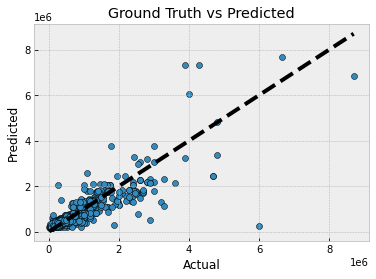

In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_label, y_predicted, edgecolors=(0, 0, 0))
ax.plot([test_label.min(), test_label.max()], [test_label.min(), test_label.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()